In [1]:
import os

import torch

from src.agents import DiscreteActorCritic
from src.networks import DiscreteActorCriticNetwork
from src.pv_env import History, PVEnvDiscrete
from src.reward import RewardDeltaPower

PV_PARAMS_PATH = os.path.join("parameters", "01_pvarray.json")
WEATHER_PATH = os.path.join("data", "weather_sim.csv")
PVARRAY_CKP_PATH = os.path.join('data', '01_pvarray_iv.json')
AGENT_CKP_PATH = os.path.join("models", "02_mppt_ac.tar")
LEARNING_RATE = 0.001
ENTROPY_BETA = 0.001
GAMMA = 0.9
N_STEPS = 1
BATCH_SIZE = 16

In [2]:
env = PVEnvDiscrete.from_file(
    PV_PARAMS_PATH,
    WEATHER_PATH,
    pvarray_ckp_path=PVARRAY_CKP_PATH,
    # states=["v_norm", "i_norm", "deg"],
    states=["v_norm", "i_norm", "dv"],
    reward_fn=RewardDeltaPower(2, 0.9),
    actions=[-10, -5, -3, -2, -1, -0.1, 0, 0.1, 1, 2, 3, 5, 10],
)
device = torch.device("cpu")
net = DiscreteActorCriticNetwork(
    input_size=env.observation_space.shape[0], n_actions=env.action_space.n
).to(device)
agent = DiscreteActorCritic(
    env=env,
    net=net,
    device=device,
    gamma=GAMMA,
    beta_entropy=ENTROPY_BETA,
    lr=LEARNING_RATE,
    n_steps=N_STEPS,
    batch_size=BATCH_SIZE,
    chk_path=AGENT_CKP_PATH,
)

INFO 2020-11-11 17:28:07,178 Dictionary readed from parameters\01_pvarray.json
INFO 2020-11-11 17:28:07,179 Starting MATLAB engine . . .
INFO 2020-11-11 17:28:07,211 MATLAB engine initializated.
INFO 2020-11-11 17:28:08,404 Model loaded succesfully.
INFO 2020-11-11 17:28:08,427 Dictionary readed from data\01_pvarray_iv.json
INFO 2020-11-11 17:28:08,429 Reading data\weather_sim.csv . . .
INFO 2020-11-11 17:28:08,445 Checkpoint loaded from models\02_mppt_ac.tar


In [3]:
agent.train(steps=1000, verbose_every=0, save_every=0)

100%|██████████| 1000/1000 [00:20<00:00, 47.89it/s]
INFO 2020-11-11 17:28:30,228 Checkpoint saved to models\02_mppt_ac.tar


INFO 2020-11-11 17:28:33,382 Calculating true MPP . . .
Calculating true MPP: 100%|##########| 834/834 [00:00<00:00, 1327.81it/s]
INFO 2020-11-11 17:28:34,012 Running P&O, step=0.2 volts . . .
Calculating PO: 100%|##########| 834/834 [00:00<00:00, 208664.37it/s]


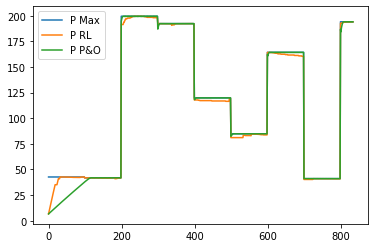

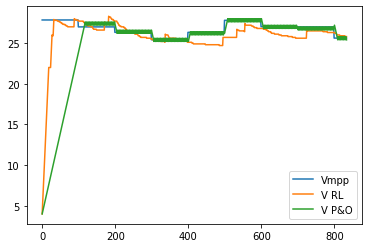

INFO 2020-11-11 17:28:34,622 PO Efficiency=94.17581414169271
INFO 2020-11-11 17:28:34,623 RL Efficiency=97.71363198204081


In [4]:
agent.exp_train_source.play_episode()
env.render_vs_true(po=True)